[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/042_cnns/cnns.ipynb)

# Redes Neuronales Convolucionales

En posts anteriores hemos presentado varias arquitecturas diferentes de `redes neuronales`. Algunos ejemplos son el [`Perceptrón Multicapa`](https://sensioai.com/blog/023_mlp_backprop) o las [`redes neuronales recurrentes`](https://sensioai.com/blog/034_rnn_intro), las cuales hemos aplicado para [predicción de series temporales](https://sensioai.com/blog/035_rnn_forecast) y varias aplicaciones de [lenguaje](https://sensioai.com/blog/038_clasificacion_texto). En este post vamos a presentar una nueva arquitectura de `red neuronal` conocida como `red neuronal convolucional`, especialmente diseñada para trabajar con imágenes.

## Introducción

Las `redes neuronales convolucionales` (CNNs) surgieron del estudio del córtex visual del cerebro y se han utilizado en el reconocimiento de imágenes desde la década de los 80. En los últimos años, gracias al aumento de la potencia computacional, la cantidad de datos de entrenamiento disponibles y los trucos ya explicados anteriormente para entrenar redes profundas, las CNNs han logrado lograr un rendimiento sobrehumano en algunas tareas visuales complejas. Este tipo de red se puede encontrar en servicios de búsqueda de imágenes, coches autónomos, sistemas de clasificación de vídeo automático y muchas otras aplicaciones. Además, las CNNs no se limitan a la percepción visual, también tienen éxito en tareas como el reconocimiento de voz y el procesamiento de datos tridimensionales.

### El córtex visual

Las neuronas del córtex visual tienen un pequeño *campo receptivo local*, lo que significa que reaccionan solo a los estímulos visuales ubicados en una región limitada del campo visual. Los campos receptivos de diferentes neuronas pueden superponerse y juntos forman el campo visual completo.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/visual_cortex.png)

Las neuronas de las primeras capas del córtex visual reaccionan solo ante ciertos patrones simples, como por ejemplo líneas horizontales mientras que otras reaccionan a líneas verticales (dos neuronas pueden tener el mismo campo receptivo pero reaccionan a diferentes orientaciones de línea). En las capas siguientes, las neuronas tienen campos receptivos más grandes y reaccionan a patrones más complejos, que pueden ser combinaciones de patrones de nivel inferior, construyendo de esta manera una jerarquía en diferentes capas que resultan finalmente en las formas y colores que vemos.

Basándose en estos conceptos, Yann LeCunn introdujo las CNNs en 1998 en la famosa arquitectura [LeNet-5](https://colab.research.google.com/drive/1fqxaTs-Ux9KQHyCJsToFTZwSNoHv9rKe#scrollTo=CMK6qB1EdfqC), utilizada por los bancos para reconocer de manera automática los números manuscritos en cheques para un procesamiento más rápido.

## La Capa Convolucional

Como veremos más adelante, las `redes convolucionales` están formadas por varias capas con diferente responsabilidad. De entre estas capas, la más importante es la `capa convolucional` la cual es responsable de identificar y construir las diferentes formas, colores y texturas de manera similar al córtex visual. Para llevar a cabo esta tarea usaremos un conjunto de *filtros* (también llamados *kernels*) los cuales deslizaremos por toda la imagen aplicando la operación *convolución*. Esta operación consiste en aplicar el producto escalar entre el filtro y los píxeles de la imagen cubiertos por el filtro, lo que se conoce como el *campo receptivo* (o *receptive field*). En el siguiente gif puedes ver esta operación en acción, en la que tenemos un filtro de 3x3 el cual deslizamos por nuestra imagen, la cual tiene una resolución de 5x5. Para cada posible posición del filtro dentro de la imagen, calculamos el producto de cada pixel por el valor del filtro correspondiente y guardamos el resultado en el mapa de salida.

![](https://miro.medium.com/max/1052/1*GcI7G-JLAQiEoCON7xFbhg.gif)

En este segundo ejemplo estamos aplicando la misma operación, pero ahora en el caso de que nuestra imagen tenga 3 canales (una imagen en color RGB). En este caso, nuestros filtros también tienen 3 canales. Además estamos aplicando más de un filtro, lo cual resulta en número de canales en el mapa de salida igual al número de filtros utilizados.

![](https://cdn-media-1.freecodecamp.org/images/gb08-2i83P5wPzs3SL-vosNb6Iur5kb5ZH43)

Vamos a ver un ejemplo de aplicación con imágenes reales, en este caso con imágenes del dataset CIFAR10 con el cual ya hemos trabajado anteriormente.

In [1]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
device

'cuda'

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(trainset[110][0])

<PIL.Image.Image image mode=RGB size=32x32 at 0x7F1623A043D0>


In [5]:
import numpy as np

train_imgs, train_labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
test_imgs, test_labels = np.array([np.array(i[0]) for i in testset]), np.array([i[1] for i in testset])

train_imgs.shape, test_imgs.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

Una vez convertidas todas las imágenes a arrays de `Numpy`, vamos a visualizar un ejemplo aleatorio.

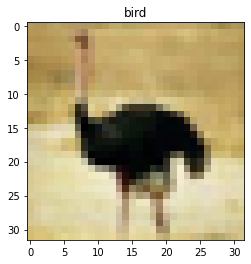

In [6]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

Ahora, vamos a aplicar un filtro definido manualmente a esta imagen. En este caso aplicaremos un filtro de 3x3 con valores de 1 en la primera fila, 0 en la central y -1 en la última. Como puedes ver en el resultado, este filtro es útil para identificar líneas horizontales.

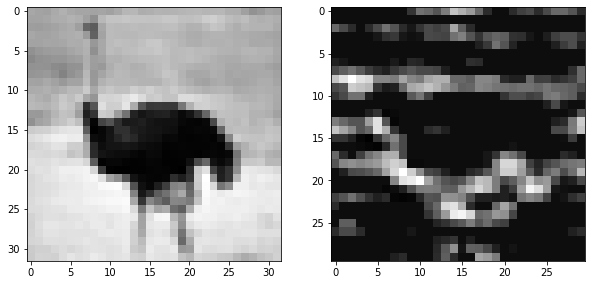

In [7]:
import numpy as np
import scipy.signal
from skimage import color
from skimage import exposure

img = color.rgb2gray(img)      

kernel = np.array([[1,1,1],
                   [0,0,0],
                   [-1,-1,-1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)   
ax2.imshow(edges, cmap=plt.cm.gray)   
plt.show()

Si aplicamos ahora el mismo filtro, pero transpuesto, obtenemos un detector de líneas verticales.

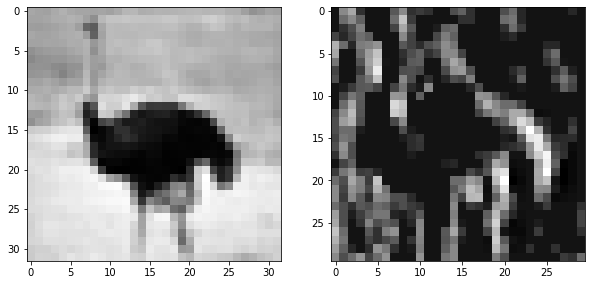

In [8]:
kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)   
ax2.imshow(edges, cmap=plt.cm.gray)   
plt.show()

De la misma manera, el siguiente filtro será útil para detectar bordes en cualquier orientación.

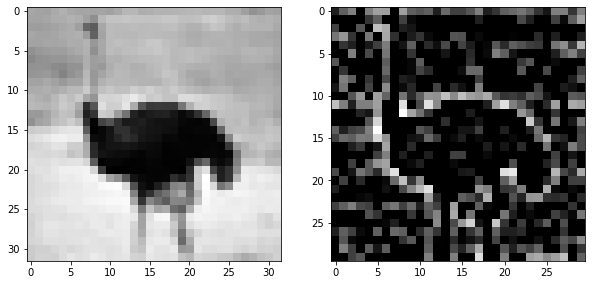

In [9]:
kernel = np.array([[0,-1,0],
                   [-1,4,-1],
                   [0,-1,0]])

edges = scipy.signal.convolve2d(img, kernel, 'valid')
edges = exposure.equalize_adapthist(edges/np.max(np.abs(edges)), clip_limit=0.03)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(img, cmap=plt.cm.gray)   
ax2.imshow(edges, cmap=plt.cm.gray)   
plt.show()

Como puedes ver, al aplicar varios filtros a nuestra imagen podemos obtener información relevante a la hora de llevar a cabo tareas tales como la clasificación de la imagen, detectar varios objetos en ella o generar una descripción textual de la misma. La pregunta ahora es: ¿Y cómo decidimos que filtros utilizar? La respuesta es fácil, dejaremos que sea la propia red neuronal quién aprenda estos valores a través del proceso de entrenamiento de manera que sea ella misma quien decida qué patrones son los más importantes a la hora de llevar a cabo su tarea. Así pues, los filtros serán ahora los parámetros de nuestra red.

### Implementación en Pytorch

En `Pytorch` tenemos implementada la capa convolucional en el clase `torch.nn.Conv2D`. A esta capa le pasamos como parámetros el número de canales de la imagen a la entrada, el número de filtros, el tamaño del filtro y otros parámetros relevantes de los que hablaremos más adelante. Si miras en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), esta capa espera un tensor a la entrada con dimensiones $(N,C_{in},H,W)$, dónde $N$ es el tamaño del *batch*, $C_{in}$ es el número de canales del mapa de entrada, $H$ es el alto y $W$ el ancho del mapa.

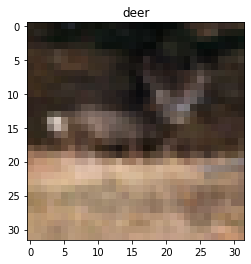

In [30]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [11]:
# img.shape, img.dtype 

In [12]:
# img_tensor = torch.from_numpy(img/255)
# img_tensor.shape, img_tensor.dtype 

In [13]:
# img_tensor = img_tensor.unsqueeze(0)
#img_tensor.shape, img_tensor.dtype

In [14]:
# img_tensor = img_tensor.permute(0, 2, 4, 1, 3).float()
# img_tensor.shape, img_tensor.dtype

In [15]:
# convertir la imágen en tensor con dimensiones (N, C_in, H, W)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0)
img_tensor = img_tensor.permute(0, 3, 1, 2).float()

img_tensor.shape, img_tensor.dtype

(torch.Size([1, 3, 32, 32]), torch.float32)

In [16]:
# aplicamos 10 filtros de tamaño 3x3

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 30, 30])

Como puedes ver las dimensiones del tensor de salida son diferentes al tensor de entrada. En primer lugar, el número de canales del mapa de entrada ahora es el número de filtros aplicados (el resultado de aplicar cada filtro se guarda en un canal). En cuanto al ancho y alto, dependerá de la relación entre el tamaño de la imagen y el del filtro. Puedes calcular estas dimensiones de la siguiente manera

$$ o = \lfloor \frac{n+2p-m}{s} \rfloor + 1 $$

donde $o$ es la dimensión de salida, $n$ la de entrada, $m$ es el tamaño del filtro y $p$ y $s$ son dos parámetros con los que podemos jugar para ajustar el tamaño de salida. $p$ es el *padding* y consiste en el número de valores extra que añadimos en los bordes para aumentar el tamaño de la entrada. $s$ es el *stride*, y controla el número de pixeles que el filtro salta en cada paso. $\lfloor \cdot \rfloor$ es el operador *floor*, que redondea cualquier resultado a la baja.

Usar $p = 1$ y $s = 1$ con un filtro de 3x3 no cambiará el tamaño de la imagen.

In [32]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 0, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 15, 15])

In [18]:
img_tensor.shape

torch.Size([1, 3, 32, 32])

Aplicar un salto de 2 pixeles en la aplicación del filtro, $s = 2$, reducirá el tamaño a la mitad.

In [19]:

conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, padding = 1, stride = 2)

output = conv(img_tensor)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([1, 10, 16, 16])

In [20]:
conv1 = torch.nn.Conv2d(in_channels = 10, out_channels = 64, kernel_size = 3, padding = 0, stride = 1)

output2 = conv1(output)

# dimensiones: (N, #filtros, H', W')
output2.shape

torch.Size([1, 64, 14, 14])

En una `red convolucional` tendremos varias de estas `capas convolucionales` en diferentes capas consecutivas, de manera que las entradas a unas capas serán las salidas de las anteriores. De esta manera, la red será capaz de construir patrones cada vez más elaborados a partir de patrones más sencillos. Puedes ver una animación del funcionamiento de esta capa en el siguiente [vídeo](https://www.youtube.com/watch?v=f0t-OCG79-U). También, en el siguiente gif, puedes ver un ejemplo de aplicación.

![](https://thumbs.gfycat.com/AffectionateMemorableGreyhounddog-size_restricted.gif)


## Capas de *Pooling*

Si bien hemos visto que jugando con los tamaños del filtro, *stride* y *padding* podemos controlar el tamaño de los mapas generados por las capas convolucionales, es también común el uso de capas *pooling* para reducir los mapas de características. 

![](https://miro.medium.com/max/1456/1*WvHC5bKyrHa7Wm3ca-pXtg.gif)

Estas capas también aplican un filtro sobre su entrada, pero en este caso es un solo filtro que además no tiene parámetros sino que aplica una función predeterminada en su campo receptivo (mínimo, máximo, promedio, etc). La idea detrás del uso de este tipo de capas es la de reducir la resolución de los mapas de características, reduciendo así el coste computacional para entrenar la `red neuronal`, pero manteniendo las características importantes para el reconocimiento de patrones.

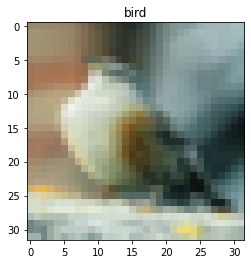

In [21]:
ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)
plt.title(classes[label])
plt.show()

In [22]:
pool = torch.nn.MaxPool2d(3, padding=1, stride=2)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0).permute(0, 3, 1, 2).float()
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 16, 16])

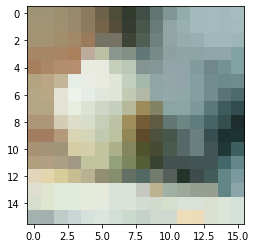

In [23]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

## Redes Convolucionales

Una vez hemos visto los comoponentes principales de las `redes convolucionales` vamos a ver un ejemplo de cómo podemos implementar una red convolucional completa para, en este caso, la clasificación de las imágenes en el dataset MNIST. En primer lugar descargamos el dataset.

In [33]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=64, shuffle=False, pin_memory=True)
}

Vamos a definir una `red convolucional` con varias `capas convolucionales` y `capas de pooling`. Para poder clasificar las imágenes, conectaremos las salidas de la última capa de la red convolucional con un `MLP` para obtener las predicciones finales.

In [25]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 392)
    self.conv2 = block(392, 196)
    self.fc = torch.nn.Linear(196 * 7 * 7, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [26]:
model = CNN()

output = model(torch.randn(64, 1, 28, 28))

Dimensiones:
Entrada:  torch.Size([64, 1, 28, 28])
conv1:  torch.Size([64, 392, 14, 14])
conv2:  torch.Size([64, 196, 7, 7])
pre fc:  torch.Size([64, 9604])
Salida:  torch.Size([64, 10])


Utilizando capas convolucionales con filtros de 3x3, *padding* 1 y *stride* 1, mantenemos las dimensiones constantes dejando la responsabilidad de reducir la resolución a las capas *pooling*. Tras cada capa convolcuional, el número de canales corresponde con el número de filtros aplicados. Para conectar la última salida de la capa convolucional a la capa lineal, tenemos que estirar el último mapa de características en un vector de una sola dimensión.

In [27]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 392)
    self.conv2 = block(392, 196)
    self.fc = torch.nn.Linear(196*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

Ahora, podemos entrenar la red utilizando nuestro bucle de entrenamiento.

In [28]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [29]:
model = CNN()
fit(model, dataloader)

val_loss 0.05010 val_acc 0.98209: 100%|██████████| 157/157 [00:03<00:00, 50.57it/s]


Epoch 1/5 loss 0.12376 val_loss 0.05010 acc 0.96187 val_acc 0.98209


val_loss 0.03984 val_acc 0.98696: 100%|██████████| 157/157 [00:04<00:00, 34.51it/s]


Epoch 2/5 loss 0.04647 val_loss 0.03984 acc 0.98537 val_acc 0.98696


val_loss 0.03203 val_acc 0.99134: 100%|██████████| 157/157 [00:03<00:00, 51.40it/s]


Epoch 3/5 loss 0.03331 val_loss 0.03203 acc 0.98946 val_acc 0.99134


val_loss 0.04440 val_acc 0.98666: 100%|██████████| 157/157 [00:03<00:00, 51.55it/s]


Epoch 4/5 loss 0.02597 val_loss 0.04440 acc 0.99185 val_acc 0.98666


val_loss 0.04261 val_acc 0.98736: 100%|██████████| 157/157 [00:03<00:00, 51.67it/s]

Epoch 5/5 loss 0.02041 val_loss 0.04261 acc 0.99342 val_acc 0.98736


Tras 5 *epochs* nuestra CNN es capaz de clasificar las imágenes en el dataset de test con una precisión cercana al $99 \%$, aunque como puedes observar tenemos *overfitting*. Puedes aplicar varias de las técnicas explicadas en este [post](https://sensioai.com/blog/031_regularization) para reducir este efecto e intentar conseguir un mejor modelo.

¿Cómo decidimos el número de capas?, ¿y el tamaño de los filtros, *padding*, *stride*, ...? Tenemos muchos valores con los que jugar, y llevar a cabo una exploración efectiva puede ser costoso. Es por esto que, a efectos prácticos, los mejor es utilizar configuraciones ya exploradas por otros (en ocasiones incluso podremos usar estas redes ya entrenadas para hacer *transfer learning*) y adaptarlas para nuestro caso concreto.

## Resumen

En este post hemos introducido la arquitectura de `red neuronal` conocida como `red neuronal convolucional`. Este tipo de redes, inspiradas en el funcionamiento del córtex visual, están especialmente diseñadas para trabajar con imágenes. Gracias a la aplicación de la `capa convolucional`, la red será capaz de reconocer diferentes formas, colores y texturas que, de manera jerárquica, irá componiendo en estructuras cada vez más complejas para poder llevar a cabo su tarea de la mejor forma posible. En futuros posts hablaremos sobre diferente arquitecturas de CNN que han aparecido durante los últimos años y que podemos utilizar para nuestras aplicaciones.